In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nozzle import Spectral, Params, Nozzle
from scipy.integrate import simpson

# Linear elements
Let $ \tilde{v}(x) = \sum_{j=1}^{N} c_ju_j(x) $ where $u_j(x)$ are tent functions that peaks at $x_j\in(-1,1)$.

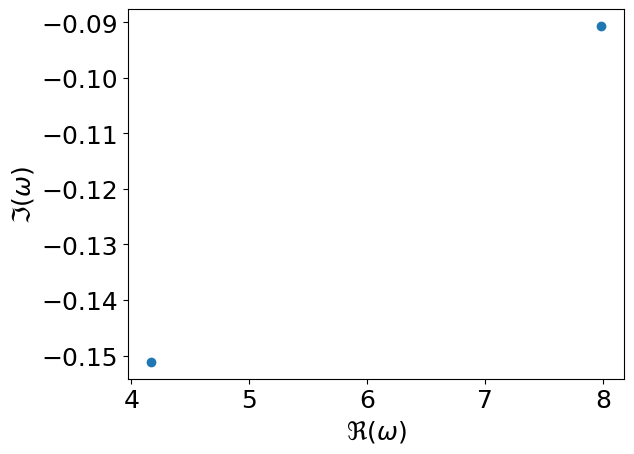

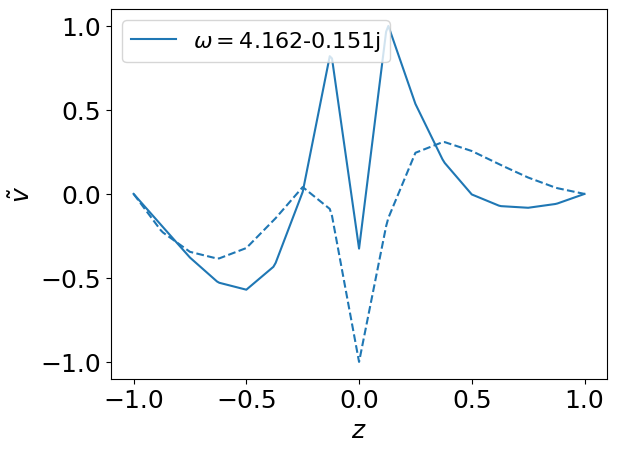

In [3]:
N = 15 # number of tent functions
M = 201 # number of points
Mm = 1.0
constant_v = False
accelerating = True
params = Params(Mm=Mm, constant_v=constant_v, accelerating=accelerating)

spectral = Spectral(M, "symmetric", "FD")
x = spectral.x
D1 = spectral.D1
D2 = spectral.D2

dx = 2/(N+1)
node = np.linspace(-1+dx,1-dx,N)

u = lambda x,n: np.piecewise(x, [np.abs(x-node[n])/dx<=1], [lambda x: -np.abs(x-node[n])/dx+1, 0])
# u_p = lambda x,n: np.piecewise(
#     x,
#     [((x-node[n])/dx>=-1) & ((x-node[n])/dx<0), ((x-node[n])/dx>=0) & ((x-node[n])/dx<1)],
#     [1/dx,-1/dx,0]
# )
# u_pp = lambda x,n: 0

nozzle = Nozzle(params, x, lambda x,n: u(x,n))
v0 = nozzle.v0

A2 = np.zeros((N,N),dtype=complex)
A1 = np.zeros((N,N),dtype=complex)
A0 = np.zeros((N,N),dtype=complex)
for i in range(N):
    for j in range(N):
        if np.abs(i-j)<=1:
            A2[i,j] = simpson(u(x,i)*u(x,j),x)
            A1[i,j] = 2j*simpson(u(x,i)*v0*(D1@u(x,j)) + u(x,i)*(D1@v0)*u(x,j),x)
            A0[i,j] = simpson(
                u(x,i)*(1-v0**2)*(D2@u(x,j)) -
                u(x,i)*(3*v0+1/v0)*(D1@v0)*(D1@u(x,j)) - 
                u(x,i)*(1-1/v0**2)*(D1@v0)**2*u(x,j) -
                u(x,i)*(v0+1/v0)*(D2@v0)*u(x,j),
                x)

nozzle.solve(A0,A1,A2)
nozzle.sort_solutions(real_range=[0.1,10], imag_range=[-1,1])
nozzle.plot_eigenvalues()
nozzle.plot_eigenfunctions(num_funcs=1)
nozzle.save_data("FE_Tent", N=N)

# Cubic B Spline
Let $ \tilde{v} = \sum_{n=0}^{N} c_nP_n(x) $, where $P_n(x)$ are cubic B spline.

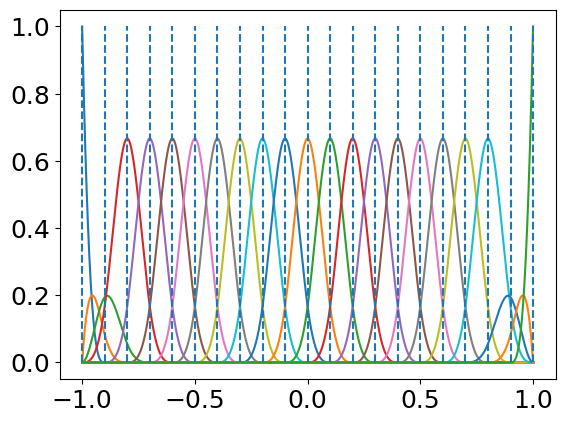

In [4]:
def phi(x:float,j:int,node):
    """ B-spline """
    h = 1/N # originally, B-spline is defined on [0,1] 
    if j == -1:
        y = x/h
        f1 = lambda y: 1 - 3*y + 3*y**2 - y**3
        f2 = lambda y: 0
        return np.piecewise(
            y,
            [(0<=y)&(y<1)],
            [f1,f2]
        )
        # return np.zeros_like(x) # Dirichlet boundary condition
    elif j == 0:
        y = x/h
        f1 = lambda y: y - 3/2*y**2 + 7/12*y**3
        f2 = lambda y: 2/3 - y + 1/2*y**2 - 1/12*y**3
        f3 = lambda y: 0
        return np.piecewise(
            y,
            [(0<=y)&(y<1), (1<=y)&(y<2)],
            [f1,f2,f3]
        )
    elif j == 1:
        y = x/h
        f1 = lambda y: y**2/2 - 11/36*y**3
        f2 = lambda y: -1/2 + 3/2*y - y**2 + 7/36*y**3
        f3 = lambda y: 3/2 - 3/2*y + 1/2*y**2 - 1/18*y**3
        f4 = lambda y: 0
        return np.piecewise(
            y,
            [(0<=y)&(y<1), (1<=y)&(y<2), (2<=y)&(y<3)],
            [f1,f2,f3,f4]
        )
    elif j == N-1:
        y = (x-node[-1])/h
        f1 = lambda y: y**2/2 + 11/36*y**3
        f2 = lambda y: -1/2 - 3/2*y - y**2 - 7/36*y**3
        f3 = lambda y: 3/2 + 3/2*y + 1/2*y**2 + 1/18*y**3
        f4 = lambda y: 0
        return np.piecewise(
            y,
            [(-1<y)&(y<=0), (-2<y)&(y<=-1), (-3<y)&(y<=-2)],
            [f1,f2,f3,f4]
        )
    elif j == N:
        y = (x-node[-1])/h
        f1 = lambda y: -y - 3/2*y**2 - 7/12*y**3
        f2 = lambda y: 2/3 + y + 1/2*y**2 + 1/12*y**3
        f3 = lambda y: 0
        return np.piecewise(
            y,
            [(-1<y)&(y<=0), (-2<y)&(y<=-1)],
            [f1,f2,f3]
        )
    elif j == N+1:
        y = (x-node[-1])/h
        f1 = lambda y: 1 + 3*y + 3*y**2 + y**3
        f2 = lambda y: 0
        return np.piecewise(
            y,
            [(-1<y)&(y<=0)],
            [f1,f2]
        )
        # return np.zeros_like(x) # Dirichlet boundary condition
    else:
        y = x/h - j
        f1 = lambda y: 4/3 + 2*y + y**2 + y**3/6
        f2 = lambda y: 2/3 - y**2 - y**3/2
        f3 = lambda y: 2/3 - y**2 + y**3/2
        f4 = lambda y: 4/3 - 2*y + y**2 - y**3/6
        f5 = lambda y: 0
        return np.piecewise(
            y, 
            [(-2<=y)&(y<-1), (-1<=y)&(y<0), (0<=y)&(y<1), (1<=y)&(y<2)], 
            [f1,f2,f3,f4,f5]
        )

def u(x,j):
    node = 2*np.linspace(0,1,N+1) - 1
    return phi((x+1)/2, j, node)

N = 20
plt.figure()
x = np.linspace(-1,1,1000) # shift the domain to [-1,1]
for n in range(-1,N+2):
    plt.plot(x, u(x,n))
plt.vlines(2*np.linspace(0,1,N+1)-1, 0,1, linestyle='--') # plot nodes

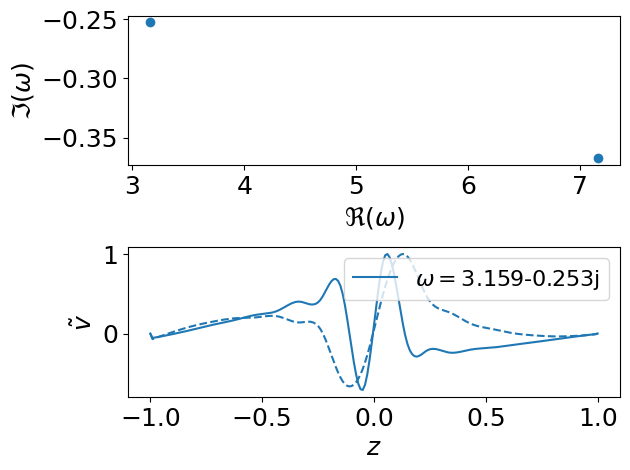

In [6]:
N = 21 # number of basis function
M = 201 # number of points
Mm = 1.0
constant_v = False
accelerating = True
params = Params(Mm=Mm, constant_v=constant_v, accelerating=accelerating)

spectral = Spectral(M, "symmetric", "FD")
x = spectral.x
D1 = spectral.D1
D2 = spectral.D2

# the index i of u_i starts from -1, but summation in my code starts from 0
# so, we need to shift the strting index of u from -1 to 0
nozzle = Nozzle(params, x, lambda x,n: u(x,n-1))
v0 = nozzle.v0

A2 = np.zeros((N+3,N+3), dtype=complex) # n from -1 to N+1
A1 = np.zeros((N+3,N+3), dtype=complex)
A0 = np.zeros((N+3,N+3), dtype=complex)
for i in range(N+3):
    for j in range(N+3):
        if np.abs(i-j) <= 3:
            A2[i,j] = simpson(u(x,i-1)*u(x,j-1),x)
            A1[i,j] = 2j*simpson(u(x,i-1)*v0*(D1@u(x,j-1)) + u(x,i-1)*(D1@v0)*u(x,j-1),x)
            A0[i,j] = simpson(
                u(x,i-1)*(1-v0**2)*(D2@u(x,j-1)) -
                u(x,i-1)*(3*v0+1/v0)*(D1@v0)*(D1@u(x,j-1)) - 
                u(x,i-1)*(1-1/v0**2)*(D1@v0)**2*u(x,j-1) -
                u(x,i-1)*(v0+1/v0)*(D2@v0)*u(x,j-1),
                x)

nozzle.solve(A0,A1,A2)
nozzle.sort_solutions(real_range=[0.1,10], imag_range=[-1,1])

fig, ax = plt.subplots(2,1)
nozzle.plot_eigenvalues(ax=ax[0])
nozzle.plot_eigenfunctions(num_funcs=1,ax=ax[1])
plt.tight_layout()
nozzle.save_data("FE_Bspline", N=N)

# SINE
$$ \omega^2\tilde{v} + 2i\omega v_0\tilde{v}' + (1-v_0^2)\tilde{v}'' = 0 $$

Let $ \tilde{v} = \sum_{n=1}^{N} c_n\sin(\frac{n\pi}{2}(x+1)) $. Using this, the equation becomes

$$ \left(\delta_{jk}\omega^2 + 2iv_0 mod(j-k,2)\left( 2\frac{jk}{j^2-k^2} \right)\omega - (1-v_0^2)\left(\frac{j\pi}{2}\right)^2\delta_{jk} \right)\mathbf{c} = \mathbf{0} $$

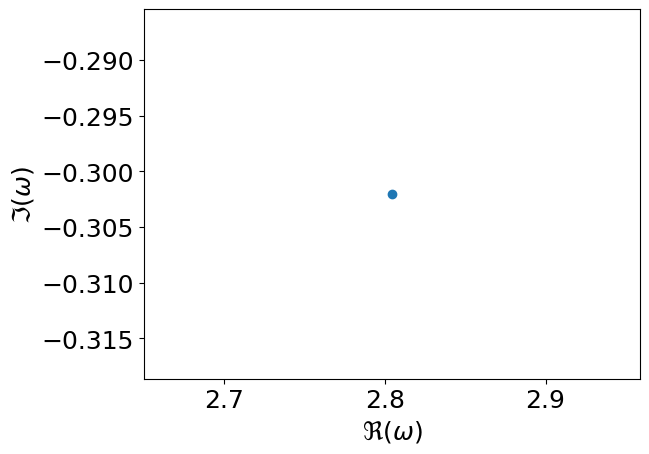

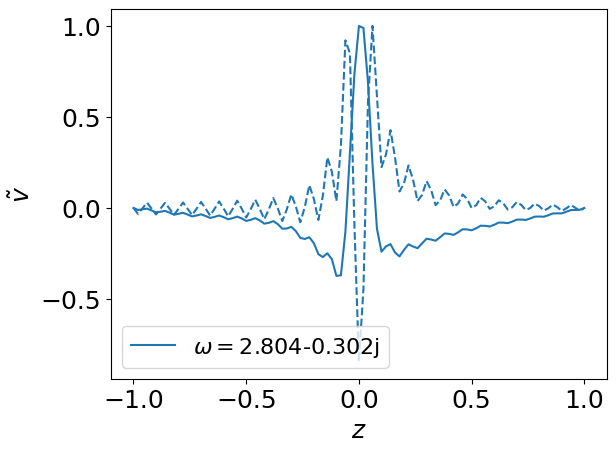

In [8]:
N = 50 # number of sine basis
M = 101 # number of points
Mm = 1.0
constant_v = False
accelerating = True

params = Params(Mm=Mm, constant_v=constant_v, accelerating=accelerating)

spectral = Spectral(M, "symmetric", "FD")
x = spectral.x
D1 = spectral.D1
D2 = spectral.D2

nozzle = Nozzle(params, x, lambda x,n: u(x,n))
v0 = nozzle.v0

L = 2
x0 = -1
u = lambda x,n: np.sqrt(2/L)*np.sin(n*np.pi/L*(x-x0))

# A2 = np.eye(N,dtype=complex)
A2 = np.zeros((N,N),dtype=complex)
A1 = np.zeros((N,N),dtype=complex)
A0 = np.zeros((N,N),dtype=complex)
for i in range(1,N+1):
    for j in range(1,N+1):
        # if i==j:
        #     A0[i-1,j-1] = -(1-v0**2)*(i*np.pi/2)**2
        # if (i-j)%2 != 0:
        #     A1[i-1,j-1] = 2j*v0 * (4/L*i*j/(i**2-j**2))
        A2[i-1,j-1] = simpson(u(x,i)*u(x,j),x)
        A1[i-1,j-1] = 2j*simpson(u(x,i)*v0*(D1@u(x,j)) + u(x,i)*(D1@v0)*u(x,j),x)
        A0[i-1,j-1] = simpson(
            u(x,i)*(1-v0**2)*(D2@u(x,j)) -
            u(x,i)*(3*v0+1/v0)*(D1@v0)*(D1@u(x,j)) - 
            u(x,i)*(1-1/v0**2)*(D1@v0)**2*u(x,j) -
            u(x,i)*(v0+1/v0)*(D2@v0)*u(x,j),
            x)
        

nozzle.solve(A0,A1,A2)
nozzle.sort_solutions(real_range=[0,6], imag_range=[-1,1])
nozzle.plot_eigenvalues()
nozzle.plot_eigenfunctions(num_funcs=1)

nozzle.save_data("FE_Sine", N=N)